# PostProcessing of the Prediction

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

from Plot import plot_cv, plot_img
from Cnn_Architecture import CourtDetection

In [2]:
model_path = "../Cnn_Architecture/court/keypoints_model.pth"
court_line = CourtDetection(model_path)

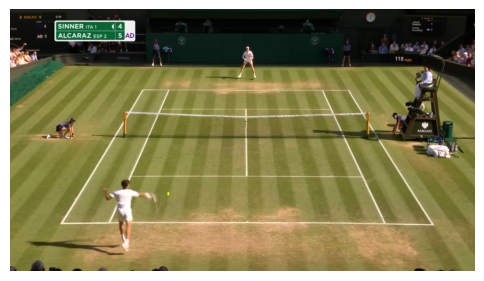

In [3]:
path = "../Data/tennis_game.png"
tennis = cv.imread(path, cv.IMREAD_COLOR_RGB)
plot_img(tennis)

In [4]:
pts = court_line.predict(tennis)
only_k = 4
pts = pts[:only_k*2] #*2 'cause we only wanna adjust the outsides corners 

In [5]:
points = np.array(pts, dtype=np.float32).reshape(-1, 2)

In [6]:
keypoints = tennis.copy()
for (x, y) in points:
    cv.circle(keypoints, (int(x), int(y)), 8, (0, 255, 0), -1)

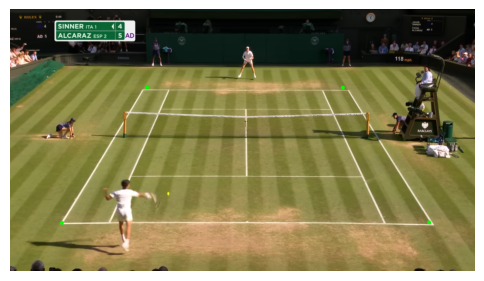

In [7]:
plot_img(keypoints)

## PostProcess

After extracting all keypoint with the model, we apply Subpixel refinement using CornerSubPix from Opencv.

For each predicted keypoint (x, y):

1. We gonna define a local search window around the point.

2. Use cornerSubPix to refine the keypoint location to subpixel accuracy.

3. If the new refined position remains within the expected neighborhood, we accept it; otherwise, we keep the original point.

In [8]:
def refine_keypoints_subpix(bgr_img, seeds, win_size = 10, zero_zone = (-1, -1), blur_ksize = 3):
    gray = cv.cvtColor(bgr_img, cv.COLOR_BGR2GRAY)
    if blur_ksize and blur_ksize > 1:
        gray = cv.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)

    h, w = gray.shape

    #cornerSubPix
    win = (win_size, win_size)
    criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_MAX_ITER, 40, 1e-3)

    refined = []
    ok_mask = []

    for (x, y) in seeds:
        #verify if the new window fits in the img
        rx = min(win_size, int(min(x, w - 1 - x)))
        ry = min(win_size, int(min(y, h - 1 - y)))
        if rx < 1 or ry < 1:
            refined.append([float(x), float(y)])
            ok_mask.append(False)
            continue

        local_win = (rx, ry)
        p = np.array([[[x, y]]], dtype=np.float32)  

        #for each point we calculate the window
        cv.cornerSubPix(gray, p, local_win, zero_zone, criteria)

        px, py = float(p[0, 0, 0]), float(p[0, 0, 1])
        if abs(px - x) <= win_size + 0.5 and abs(py - y) <= win_size + 0.5:
            refined.append([px, py])
            ok_mask.append(True)
        else:
            refined.append([float(x), float(y)])
            ok_mask.append(False)

    return np.array(refined, dtype=np.float32), np.array(ok_mask, dtype=bool)

In [ ]:
def plot_keypoints_comparison(img, keypoints, refined_xy, ok_mask, show_idx=True):
    out = img.copy()
    refined = np.asarray(refined_xy, dtype=np.float32).reshape(-1, 2)
    ok_mask = np.asarray(ok_mask, dtype=bool).reshape(-1)

    n = min(len(keypoints), len(refined), len(ok_mask)) 

    for i in range(n):
        sx, sy = keypoints[i]
        rx, ry = refined[i]
        p_seed = (int(round(sx)), int(round(sy)))
        p_ref  = (int(round(rx)), int(round(ry)))

        cv.circle(out, p_seed, 5, (0, 0, 255), 2, lineType=cv.LINE_AA)
        cv.line(out, p_seed, p_ref, (255, 0, 0), 1, lineType=cv.LINE_AA)

        if ok_mask[i]:
            cv.circle(out, p_ref, 4, (0, 255, 0), -1, lineType=cv.LINE_AA)
        else:
            cv.drawMarker(out, p_ref, (0, 255, 255),
                          markerType=cv.MARKER_TILTED_CROSS,
                          markerSize=12, thickness=2, line_type=cv.LINE_AA)

        if show_idx:
            cv.putText(out, str(i), (p_seed[0] + 6, p_seed[1] - 6),
                       cv.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255),
                       1, cv.LINE_AA)

    plot_img(out) #change to plot_cv(out) to better see the change of positions

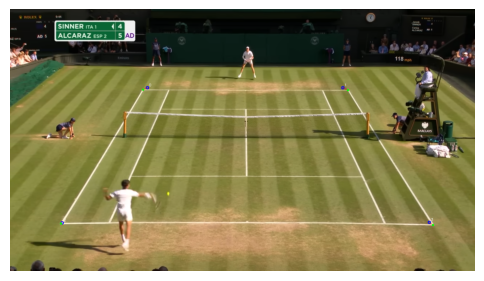

In [ ]:
refined, ok = refine_keypoints_subpix(tennis, points, win_size = 60)
plot_keypoints_comparison(tennis, points, refined, ok)

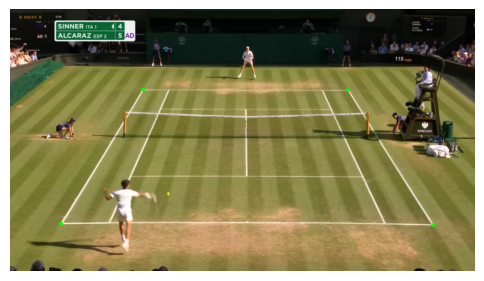

In [11]:
keypoints_rf = tennis.copy()
for (x, y) in refined:
    cv.circle(keypoints_rf, (int(round(x)), int(round(y))), 8, (0, 255, 0), -1)

plot_img(keypoints_rf)

## Hull

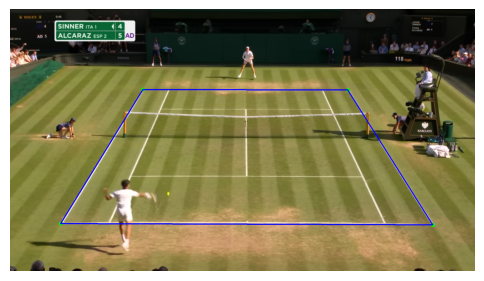

In [12]:
hull = cv.convexHull(refined)
hull_int = hull.astype(int)
cv.polylines(keypoints_rf, [hull_int], isClosed = True, color = (0, 0, 255), thickness=3)
plot_img(keypoints_rf)